In [1]:
%matplotlib inline
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

## Finding all DESI observations of MostHosts objects

The MostHostsDesi class will match all of the RA/Dec from Mosthosts to the daily tables of observations from DESI.  It builds a (somewhat complicated) Pandas datastructure with all of the matches, and then writes that data structure to a csv file.  Look at that file for documentation on how it works.

In [2]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Release can be one of : daily , everest , fuji , guadalupe , fujilupe
#  (fujilupe is the union of fuji and guadalupe)
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
subset = "daily"
mhd = MostHostsDesi( release=subset, force_regen=False)

[2022-06-02 15:11:12,962 - INFO] - Loading mosthosts table...
[2022-06-02 15:11:13,823 - INFO] - ...mosthosts table loaded.
[2022-06-02 15:11:13,846 - INFO] - Read dataframes from pkl files


In [3]:
# Print out some statistics
print( f'...as of when the csv and pkl files were last regenerated:' )
print( f'{len(mhd.df)} entries in the MostHosts database' )
print( f'{len(mhd.df.groupby("snname"))} different SNe/AGN in MostHosts database' )
print( f'{mhd.df["z"].notnull().sum()} hosts have at least one DESI zwarn=0 redshift' )
print( f'{len( mhd.df[ mhd.df["z"].notnull() ].groupby( "snname" ) )} SNe/AGN have at least one host observed by DESI' )
# I put this here as a self-consistency check between my two dataframes
print( f'The same number again: {len( mhd.haszdf[ mhd.haszdf["zwarn"]==0 ].reset_index().groupby( "snname" ) )}' )

# Make a dataframe that's like df, but that omits all QSOs and that all have at least one redshift
print( '' )
justsne = mhd.haszdf[ mhd.haszdf['zwarn']==0 ]
justsne = justsne[ justsne['program'].apply( lambda x: 'QSO' not in x ) ]
print( f'{len( justsne.reset_index().groupby( ["snname", "index"] ))} non-QSO MostHosts have at least one DESI observation' )
print( f'{len( justsne.reset_index().groupby( "snname" ))} SNe (i.e. non-QSO targets) have at least one host observed by DESI' )


...as of when the csv and pkl files were last regenerated:
20174 entries in the MostHosts database
14958 different SNe/AGN in MostHosts database
4372 hosts have at least one DESI zwarn=0 redshift
4238 SNe/AGN have at least one host observed by DESI
The same number again: 4238

3507 non-QSO MostHosts have at least one DESI observation
3373 SNe (i.e. non-QSO targets) have at least one host observed by DESI


In [5]:
# If you want to figure out which supernovae have multiple hosts, you can poke at the mhd.df dataframe similar to the following

origtablehostcount = mhd.df.reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(origtablehostcount == i).sum()} candidates in the mosthosts table have {i} hosts' )
# print( f'The candidates with 3 observed hosts are: {origtablehostcount[origtablehostcount == 5].index.values}' )

print( '' )

obshostcount = mhd.df[ mhd.df['z'].notnull() ].reset_index().groupby( "snname" ).count()["index"]
for i in range( 1, 8 ):
    print( f'{(obshostcount == i).sum()} candidates have {i} hosts observed by DESI with zwarn=0' )

11240 candidates in the mosthosts table have 1 hosts
2367 candidates in the mosthosts table have 2 hosts
1217 candidates in the mosthosts table have 3 hosts
123 candidates in the mosthosts table have 4 hosts
10 candidates in the mosthosts table have 5 hosts
0 candidates in the mosthosts table have 6 hosts
1 candidates in the mosthosts table have 7 hosts

4114 candidates have 1 hosts observed by DESI with zwarn=0
115 candidates have 2 hosts observed by DESI with zwarn=0
8 candidates have 3 hosts observed by DESI with zwarn=0
1 candidates have 4 hosts observed by DESI with zwarn=0
0 candidates have 5 hosts observed by DESI with zwarn=0
0 candidates have 6 hosts observed by DESI with zwarn=0
0 candidates have 7 hosts observed by DESI with zwarn=0


In [40]:
mhd.df.xs( '09ac' )

,ra,dec,pmra,pmdec,ref_epoch,override,hemisphere,sn_ra,sn_dec,sn_z,program,priority,tns_name,iau_name,ptfiptf_name,spname,z,zerr,zdisp
index,,,,,,,,,,,,,,,,,,,
1,186.14969,47.237527,0.0,0.0,0.0,False,north,186.147399,47.237755,0.161,PTF-iPTF,1.0,None,None,PTF09ac,PTF09ac,0.163469,0.000044,0.0


In [5]:
# Match mosthosts to main desi targets
mhd.find_main_targets( force_regen=False )

print( f"{len(mhd.maintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts show up in DESI main targets" )

subdf = mhd.maintargets[ mhd.maintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(mhd.df)} mosthosts have a bgs_target > 0" )

_justsnedf = mhd.df[ ['QSO' not in p for p in mhd.df['program'] ] ]
_justsnemaintargets = mhd.maintargets[ [ 'QSO' not in p for p in mhd.maintargets['program'] ] ]

print( f"{len(_justsnemaintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justsnedf)} non-QSO mosthosts show up in DESI main targets" )
subdf = _justsnemaintargets[ _justsnemaintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justsnedf)} non-QSO mosthosts have a bgs_Target > 0" )

# A long way to do subtraction

_justqsodf = mhd.df[ ['QSO' in p for p in mhd.df['program'] ] ]
_justqsomaintargets = mhd.maintargets[ ['QSO' in p for p in mhd.maintargets['program'] ] ]
print( f"{len(_justqsomaintargets.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justqsodf)} QSO mosthosts show up in DESI main targets" )
subdf = _justqsomaintargets[ _justqsomaintargets['bgs_target'] > 0 ]
print( f"{len(subdf.groupby( ['spname', 'index'] ).first())} "
       f"of {len(_justqsodf)} QSO mosthosts have a bgs_Target > 0" )



[2022-05-18 11:54:20,275 - INFO] - MainTargets info read from mosthosts_desi_maintargets.pkl


12396 of 20174 mosthosts show up in DESI main targets
10586 of 20174 mosthosts have a bgs_target > 0
10656 of 18173 non-QSO mosthosts show up in DESI main targets
10353 of 18173 non-QSO mosthosts have a bgs_Target > 0
1740 of 2001 QSO mosthosts show up in DESI main targets
233 of 2001 QSO mosthosts have a bgs_Target > 0


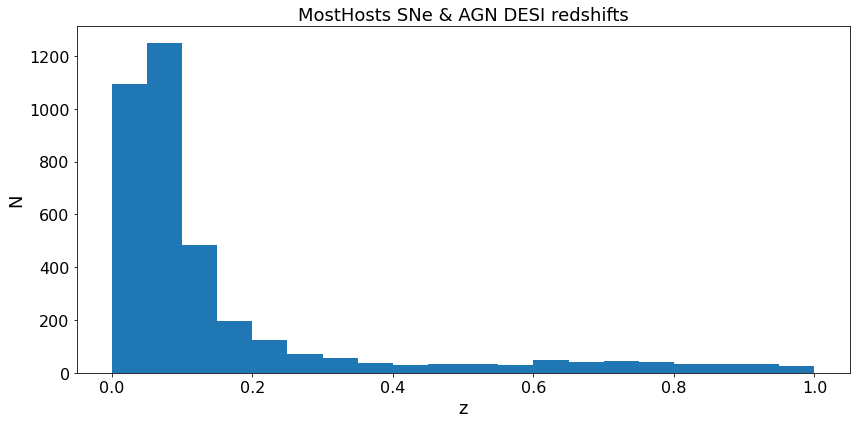

In [6]:
# Make a histogram of independent supernova z and AGN.  The host z might not be the right one, as
#   the plot just naively grabs the first host listed for each SN.

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe & AGN DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()
fig.savefig( f'mosthostsz_{subset}.svg' )


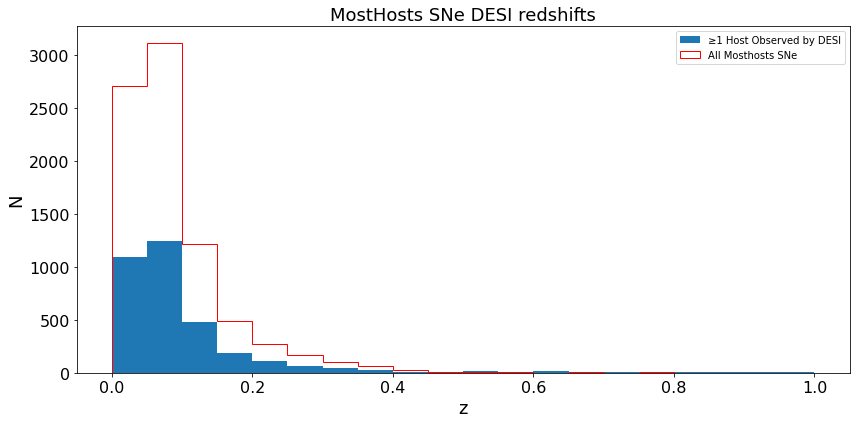

In [7]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = justsne.groupby( 'snname' ).agg('first')

allmhjustsne = mhd.df.groupby( 'snname' ).agg('first')
allmhjustsne = allmhjustsne[ allmhjustsne['program'].apply( lambda x: 'QSO' not in x ) ]

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20, label="≥1 Host Observed by DESI" )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )

ax.hist( allmhjustsne['sn_z'], range=(0, 1), bins=20, histtype='step', color='red', label="All Mosthosts SNe" )

ax.legend()

fig.show()
fig.savefig( f'mosthosts_justsnez_{subset}.svg' )


/tmp/ipykernel_213511/3901605094.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )


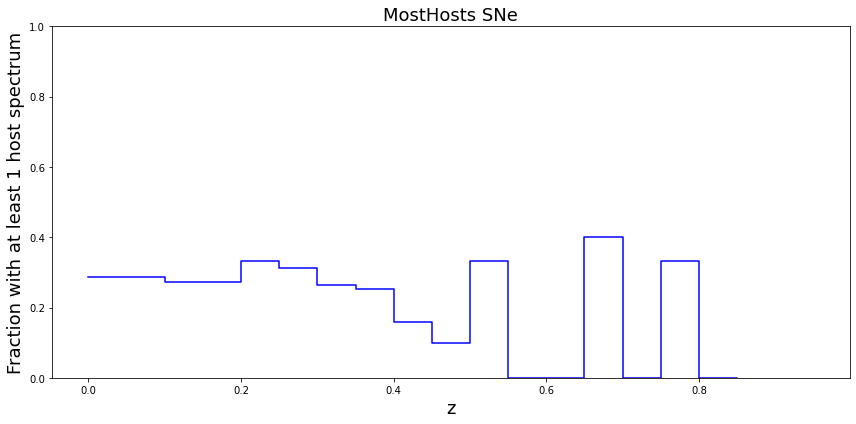

In [8]:
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1)
obshist, obsbins = np.histogram( subframe['sn_z'], range=(0,1), bins=20 )
allhist, allbins = np.histogram( allmhjustsne['sn_z'], range=(0,1), bins=20 )
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('Fraction with at least 1 host spectrum', fontsize=18)
ax.set_title( 'MostHosts SNe', fontsize=18 )
ax.set_ylim( 0, 1 )
ax.step( allbins[:-1], obshist/allhist, where='post', color='blue' )
fig.show()


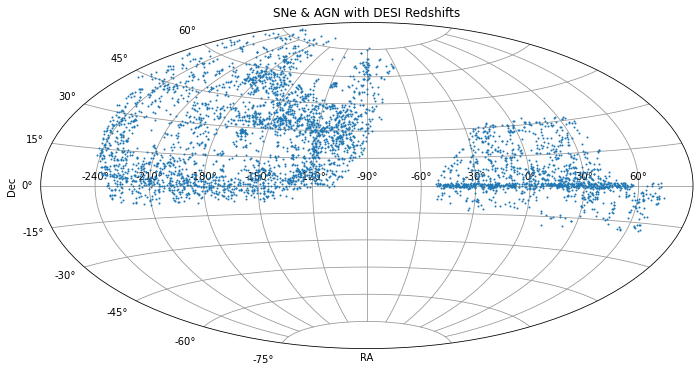

In [9]:
# Plot them on the sky

subframe = mhd.df[ mhd.df['z'].notnull() ].groupby( 'snname' ).agg('first')


fig = pyplot.figure( figsize=(12,6) )
ax = fig.add_subplot(1, 1, 1, projection='aitoff' )
# I want to plot the aitoff projection not having 0 at the center
# I don't know if there's a simple argument to give to the axes for
# this, so I'll manually offset my RAs, and then manually edit the
# tick labels, to offset by raoff degrees.
raoff = 90
ras = ( subframe['ra'].values + raoff ) * math.pi/180.
ras[ ras < -math.pi ] = ras[ ras < -math.pi ] + 2*math.pi
ras[ ras >= math.pi ] = ras[ ras >= math.pi ] - 2*math.pi
ax.set_longitude_grid( 30 )
ax.set_latitude_grid( 15 )
ax.grid( which='major', color='#999999' )
ax.plot( ras, subframe['dec'].values*math.pi/180., linestyle='None', marker='o', markersize=1 )
fig.canvas.draw()
labels = [ f'{float(lab.get_text()[:-1])-raoff:.0f}°' for lab in ax.get_xticklabels() ]
ax.set_xticklabels( labels )
# Remove the 75° label so it doesn't overlap the title.
# THere's probably a more elegant way to do this.
labels = [ lab for lab in ax.get_yticklabels()[:-1] ] + ['']
ax.set_yticklabels( labels )
ax.set_xlabel( "RA" )
ax.set_ylabel( "Dec" )
ax.set_title( "SNe & AGN with DESI Redshifts" )
fig.show()
fig.savefig( f'mosthostdesiz_skydist_{subset}.svg' )

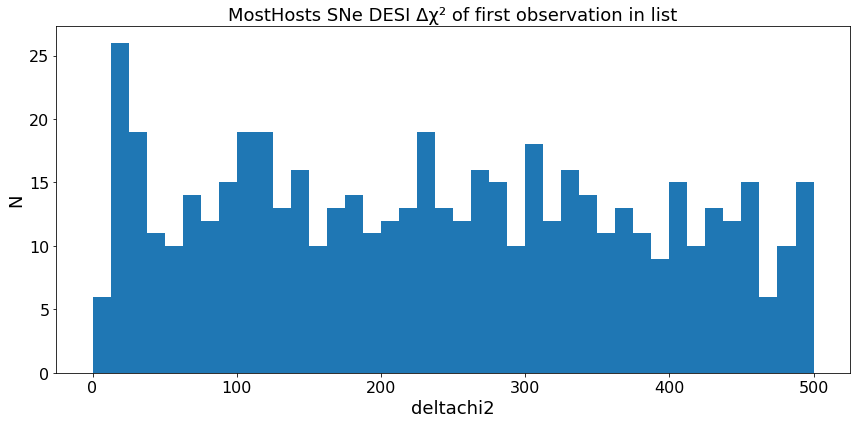

In [10]:
subframe = justsne.groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['deltachi2'].values, range=(0,500), bins=40)
ax.set_xlabel('deltachi2', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI Δχ² of first observation in list', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
fig.show()


In [11]:
subframe = justsne.groupby( 'snname' ).agg('first')
dexes = subframe.index.values
ztfobjs = subframe[ [ it[0:3]=='ZTF' for it in dexes ] ]
# I know I could have done a pandas count something something,
# but I might want this subframe later.
print( f"There are {len(ztfobjs)} SNe with DESI-observed hosts whose names start with \"ZTF\"" )

There are 1911 SNe with DESI-observed hosts whose names start with "ZTF"


In [12]:
ztfobjs[ ['z', 'ra', 'dec' ] ]

,z,ra,dec
snname,,,
ZTF17aaaiwbs,0.326757,127.792220,6.273444
ZTF17aabxoet,0.345554,207.778005,45.918847
ZTF17aabxonw,0.290645,178.779339,52.030977
ZTF17testa,0.710282,148.283602,14.981531
ZTF18aaabiok,0.441611,121.874529,15.580751
...,...,...,...
ZTF20acizlhn,0.297178,353.552710,7.350086
ZTF20acizliy,0.042701,348.405277,4.149287
ZTF20acjetyf,0.032921,57.904546,-10.056438


In [13]:
ztfobjs['program'].unique()

array(['SNe_Ia', 'ZTFmarshal', 'SNe_Ia/RCF/ZTFmarshal',
       'SNe_Ia/ZTFmarshal', 'RCF', 'RCF/ZTFmarshal', 'SNe_Ia/RCF',
       'IIps/ZTFmarshal', 'RCF/IIps/ZTFmarshal', 'SNe_Ia/IIps/ZTFmarshal',
       'SNe_Ia/RCF/Anna', 'SNe_Ia/RCF/IIps/ZTFmarshal', 'one_shot_dL',
       'Anna/ZTFmarshal', 'RCF/RCF/RCF/ZTFmarshal/ZTFmarshal'],
      dtype=object)

In [14]:
# ztfobjs['program'].values is an object, not a string, so this is convolted
ztfsne = ztfobjs[ np.char.find( np.array( ztfobjs['program'].values, dtype=str ), 'SNe_Ia' ) >= 0 ]
print( f'There are {len(ztfsne)} SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"' )

There are 815 SNe with program including "SNe_Ia" that are observed by DESI and that have names starting with "ZTF"


In [15]:
justptf = justsne[ justsne['ptfiptf_name'] != 'None' ]
print( f'There are {len(justptf)} SNe with a non-"None" ptfiptf_name' )

There are 695 SNe with a non-"None" ptfiptf_name


In [16]:
pandas.options.display.max_rows = 500
justptf[ ['ptfiptf_name', 'ra', 'dec', 'z'] ]

ptfiptf_name  \
snname index targetid            tileid petal night                   
09ac   1     39633204071631854   20620  9     20220421      PTF09ac   
09aj   1     39627943986595403   23097  8     20220406      PTF09aj   
09alu  1     39633304558764813   174    4     20210405     PTF09alu   
                                 182    4     20210506     PTF09alu   
09amm  1     39633039919156981   25475  1     20220512     PTF09amm   
...                                                             ...   
15wd   1     39633321822522160   81058  2     20210324     iPTF15wd   
15wk   1     39628243766084410   24481  9     20211021     iPTF15wk   
15xc   1     39632945849304349   21175  0     20210516     iPTF15xc   
15zr   1     39633311340954958   81066  0     20210326     iPTF15zr   
             2305843015475793700 41610  3     20220316     iPTF15zr   

                                                                ra        dec  \
snname index targetid            tileid petal night                             
09ac   1     39633204071631854   20620  9     20220421  186.149690  47.237527   
09aj   1     39627943986595403   23097  8     20220406  146.376831   6.539819   
09alu  1     39633304558764813   174    4     20210405  214.572816  53.788987   
                                 182    4     20210506  214.572816  53.788987   
09amm  1     39633039919156981   25475  1     20220512  230.872538  37.878850   
...                                                            ...        ...   
15wd   1     39633321822522160   81058  2     20210324  174.725250  55.057643   
15wk   1     39628243766084410   24481  9     20211021  128.766206  19.185778   
15xc   1     39632945849304349   21175  0     20210516  186.079167  33.183806   
15zr   1     39633311340954958   81066  0     20210326  179.745833  54.239028   
             2305843015475793700 41610  3     20220316  179.745833  54.239028   

                                                               z  
snname index targetid            tileid petal night               
09ac   1     39633204071631854   20620  9     20220421  0.163469  
09aj   1     39627943986595403   23097  8     20220406  0.086857  
09alu  1     39633304558764813   174    4     20210405  0.074413  
                                 182    4     20210506  0.074455  
09amm  1     39633039919156981   25475  1     20220512  0.066120  
...                                                          ...  
15wd   1     39633321822522160   81058  2     20210324  0.057354  
15wk   1     39628243766084410   24481  9     20211021  0.208930  
15xc   1     39632945849304349   21175  0     20210516  0.021921  
15zr   1     39633311340954958   81066  0     20210326  0.012237  
             2305843015475793700 41610  3     20220316  0.012212  

[695 rows x 4 columns]

In [17]:
mhd.haszdf

ra  \
snname     index targetid          tileid petal night                  
09ac       1     39633204071631854 20620  9     20220421  186.149690   
09aj       1     39627943986595403 23097  8     20220406  146.376831   
09alu      1     39633304558764813 174    4     20210405  214.572816   
                                   182    4     20210506  214.572816   
09amm      1     39633039919156981 25475  1     20220512  230.872538   
...                                                              ...   
unknown-89 1     2323566045429760  1536   4     20211002  344.953169   
unknown-92 1     39627803292865470 23135  6     20211009   26.647073   
unknown-95 1     39627808841928364 9366   6     20211008  357.360260   
unknown-97 2     39627785186050852 4135   8     20211001   27.269729   
unknown-98 1     39627785601288463 25381  5     20220203   52.104573   

                                                                dec  pmra  \
snname     index targetid          tileid petal night                       
09ac       1     39633204071631854 20620  9     20220421  47.237527   0.0   
09aj       1     39627943986595403 23097  8     20220406   6.539819   0.0   
09alu      1     39633304558764813 174    4     20210405  53.788987   0.0   
                                   182    4     20210506  53.788987   0.0   
09amm      1     39633039919156981 25475  1     20220512  37.878850   0.0   
...                                                             ...   ...   
unknown-89 1     2323566045429760  1536   4     20211002   0.186418   0.0   
unknown-92 1     39627803292865470 23135  6     20211009   0.867197   0.0   
unknown-95 1     39627808841928364 9366   6     20211008   0.631878   0.0   
unknown-97 2     39627785186050852 4135   8     20211001   0.056582   0.0   
unknown-98 1     39627785601288463 25381  5     20220203  -0.048783   0.0   

                                                          pmdec  ref_epoch  \
snname     index targetid          tileid petal night                        
09ac       1     39633204071631854 20620  9     20220421    0.0        0.0   
09aj       1     39627943986595403 23097  8     20220406    0.0        0.0   
09alu      1     39633304558764813 174    4     20210405    0.0        0.0   
                                   182    4     20210506    0.0        0.0   
09amm      1     39633039919156981 25475  1     20220512    0.0        0.0   
...                                                         ...        ...   
unknown-89 1     2323566045429760  1536   4     20211002    0.0        0.0   
unknown-92 1     39627803292865470 23135  6     20211009    0.0        0.0   
unknown-95 1     39627808841928364 9366   6     20211008    0.0        0.0   
unknown-97 2     39627785186050852 4135   8     20211001    0.0        0.0   
unknown-98 1     39627785601288463 25381  5     20220203    0.0        0.0   

                                                          override hemisphere  \
snname     index targetid          tileid petal night                           
09ac       1     39633204071631854 20620  9     20220421     False      north   
09aj       1     39627943986595403 23097  8     20220406     False      south   
09alu      1     39633304558764813 174    4     20210405     False      north   
                                   182    4     20210506     False      north   
09amm      1     39633039919156981 25475  1     20220512     False      north   
...                                                            ...        ...   
unknown-89 1     2323566045429760  1536   4     20211002     False      south   
unknown-92 1     39627803292865470 23135  6     20211009     False      south   
unknown-95 1     39627808841928364 9366   6     20211008     False      north   
unknown-97 2     39627785186050852 4135   8     20211001     False      south   
unknown-98 1     39627785601288463 25381  5     20220203     False      south   

                                                          

In [18]:
# Get a count of how many times each host has zwarn=0 observations
numobs = mhd.haszdf.groupby(level=[0,1]).aggregate('count').rename( {'ra': 'numobs'}, axis=1 )['numobs']

In [19]:
numobs[numobs>3]

snname                      index
09iag                       1        4
10ctd                       1        4
10wxp                       1        4
12dnn                       1        6
13adc                       1        7
AGN_1005                    1        4
AGN_1025                    1        4
AGN_1070                    1        5
AGN_1155                    1        6
AGN_1163                    1        4
AGN_1235                    1        4
AGN_1242                    1        4
AGN_1280                    1        4
AGN_1317                    1        4
AGN_1351                    1        6
AGN_1486                    1        4
AGN_1520                    1        6
AGN_1548                    1        4
AGN_1612                    1        5
AGN_1643                    1        4
AGN_1695                    1        4
AGN_1781                    1        4
AGN_188                     1        6
AGN_1893                    1        5
AGN_196                     1 

In [20]:
mhd.haszdf.xs( 'ZTF18aavniyw', level=0 )

ra        dec  pmra  \
index targetid            tileid petal night                                   
1     39633274766623836   20593  6     20220317  172.876147  51.628972   0.0   
                          22162  1     20220218  172.876147  51.628972   0.0   
                          81064  4     20210327  172.876147  51.628972   0.0   
      2305843015459014979 81088  6     20210404  172.876147  51.628972   0.0   

                                                 pmdec  ref_epoch  override  \
index targetid            tileid petal night                                  
1     39633274766623836   20593  6     20220317    0.0        0.0     False   
                          22162  1     20220218    0.0        0.0     False   
                          81064  4     20210327    0.0        0.0     False   
      2305843015459014979 81088  6     20210404    0.0        0.0     False   

                                                hemisphere       sn_ra  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317      north  172.875062   
                          22162  1     20220218      north  172.875062   
                          81064  4     20210327      north  172.875062   
      2305843015459014979 81088  6     20210404      north  172.875062   

                                                    sn_dec   sn_z  ...  \
index targetid            tileid petal night                       ...   
1     39633274766623836   20593  6     20220317  51.629381  0.055  ...   
                          22162  1     20220218  51.629381  0.055  ...   
                          81064  4     20210327  51.629381  0.055  ...   
      2305843015459014979 81088  6     20210404  51.629381  0.055  ...   

                                                iau_name  ptfiptf_name  \
index targetid            tileid petal night                             
1     39633274766623836   20593  6     20220317     None          None   
                          22162  1     20220218     None          None   
                          81064  4     20210327     None          None   
      2305843015459014979 81088  6     20210404     None          None   

                                                    spname         z  \
index targetid            tileid petal night                           
1     39633274766623836   20593  6     20220317  AT2018ceb  0.055007   
                          22162  1     20220218  AT2018ceb  0.054975   
                          81064  4     20210327  AT2018ceb  0.054987   
      2305843015459014979 81088  6     20210404  AT2018ceb  0.054993   

                                                     zerr zwarn          chi2  \
index targetid            tileid petal night                                    
1     39633274766623836   20593  6     20220317  0.000007   0.0  19777.946017   
                          22162  1     20220218  0.000008   0.0  15133.183074   
                          81064  4     20210327  0.000005   0.0  26394.147615   
      2305843015459014979 81088  6     20210404  0.000034   0.0   8887.532886   

                                                    deltachi2  spectype  \
index targetid            tileid petal night                              
1     39633274766623836   20593  6     20220317  16177.535978    GALAXY   
                          22162  1     20220218  10326.905492    GALAXY   
                          81064  4     20210327  29484.511359    GALAXY   
      2305843015459014979 81088  6     20210404   1208.371272    GALAXY   

                                                 subtype  
index targetid            tileid petal night              
1     39633274766623836   20593  6     20220317           
                          22162  1     20220218           
                          81064  4     20210327           
      2305843015459014979 81088  6     20210404           

[4 rows x 23 columns]

In [21]:
mhd.haszdf[ mhd.haszdf.spname=='2004hx' ]

,,,,,,ra,dec,pmra,pmdec,ref_epoch,override,hemisphere,sn_ra,sn_dec,sn_z,...,iau_name,ptfiptf_name,spname,z,zerr,zwarn,chi2,deltachi2,spectype,subtype
snname,index,targetid,tileid,petal,night,,,,,,,,,,,,,,,,,,,,,
2004hx,1,39627761244964607,20675,9,20211219,40.302882,-0.877206,0.0,0.0,0.0,False,north,40.3025,-0.879444,0.0382,...,None,None,2004hx,0.182333,0.000005,0.0,9202.791659,6316.372048,GALAXY,


In [22]:
mhd.df[ mhd.df.spname=="2004hx" ]

ra       dec  pmra  pmdec  ref_epoch  override  \
snname index                                                          
2004hx 1      40.302882 -0.877206   0.0    0.0        0.0     False   
       2      40.304096 -0.876849   0.0    0.0        0.0     False   

             hemisphere    sn_ra    sn_dec    sn_z  program  priority  \
snname index                                                            
2004hx 1          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   
       2          north  40.3025 -0.879444  0.0382  SDSS_II       1.0   

             tns_name iau_name ptfiptf_name  spname         z      zerr  zdisp  
snname index                                                                    
2004hx 1         None     None         None  2004hx  0.182333  0.000005    0.0  
       2         None     None         None  2004hx       NaN       NaN    NaN